In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='ticks')
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '../induction_analysis')

import Analysis.induction_analysis as ia
import Analysis.induction_plots as ip
from Analysis import filters

from lab_repo.classes.place_cell_classes import pcExperimentGroup
import lab_repo.analysis.behavior_analysis as ba

from Experiments import SingleCellExperiment

import pandas as pd

import numpy as np
from scipy.stats import binned_statistic, sem, ttest_rel, ttest_1samp

import cPickle as pkl

/home/sebi/code/analysis/analysis-scripts/induction_analysis/Analysis/induction_analysis.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/sebi/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sebi/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sebi/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.

In [2]:
# Initialize Group

expt_ids = [22745, 22757, 23845, 23890, 23841, 23901] + [24699, 24760, 24702, 24987]
mps = ['/data/Sebi/2p/svr153/102919/MarkPoints-10072019-ref-003', 
      '/data/Sebi/2p/svr154/103019/MarkPoints-10302019-1254-001',
      '/data/Sebi/2p/svr159/010820/MarkPoints-01082020-1318-001',
      '/data/Sebi/2p/svr160/010820/MarkPoints-01082020-1318-001',
      '/data/Sebi/2p/svr161/010920/MarkPoints-01092020-1404-003',
      '/data/Sebi/2p/svr164/011020/MarkPoints-01102020-1135-002',
      '/data3/Sebi/2p/svr165/030320/MarkPoints-02282020-induce-002',
      '/data3/Sebi/2p/svr166/030320/MarkPoints-02282020-induce-002',
      '/data3/Sebi/2p/svr169/030320/MarkPoints-02282020-induce-002',
      '/data3/Sebi/2p/svr174/030820/MarkPoints-03082020-induction-001']

expts = [SingleCellExperiment.SingleCellExperiment(x, mp) for x, mp in zip(expt_ids, mps)]

pc_kwargs = {'imaging_label': 'suite2p',
                         'nPositionBins': 100,
                         'channel': 'Ch2',
                         'demixed': False,
                         'pf_subset': None,
                         'signal': 'spikes'}

grp = pcExperimentGroup(expts, label='sparse_targeted', **pc_kwargs)

filter_overwrite = False

# Should we remove spatial dist requirement?
stim_filter = filters.grp_stim_filter(grp, spatial_dist=75, label='suite2p', overwrite=filter_overwrite, activity_filter=True)
ind_filter = filters.grp_induction_filter(grp, stim_filter=stim_filter, overwrite=filter_overwrite)
nostim_filter = filters.grp_unstimmed_filter(grp, exclude_baseline_stim=True, overwrite=filter_overwrite)
nostim_ind_filter = filters.grp_unstimmed_formation_filter(grp, stim_filter=nostim_filter, overwrite=filter_overwrite)
prefix = '/home/sebi/plots/ind/sparse_targeted/sparse_targeted_'


# Exclude experiments with no stimmed cells
expts = [expt for expt in expts if len(expt.rois(roi_filter=stim_filter))]
grp = pcExperimentGroup(expts, label='sparse_targeted', **pc_kwargs)

## Plots

In [11]:
# Setup
from matplotlib import rc
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['boxplot.boxprops.linewidth'] = 1
plt.rcParams['axes.unicode_minus'] = False

rc('font',**{'family':'sans-serif','sans-serif':['helvetica', 'sans-serif']})

def clean(ax, full=False, offset=0):
    if full:
        sns.despine(ax=ax, left=True, bottom=True, offset=offset)
        ax.set_yticks([])
        ax.set_xticks([])
    else:
        sns.despine(ax=ax, offset=offset)

### Activity Centroids

Activity Centroid Dist (POST): Stim=30.8632814145 3.82736993394, No Stim=51.8217600341 1.10456051811, p=0.00036314348712, 0.00173708005867
Activity Centroid Dist (24H): Stim=37.8172134564 7.14956779547, No Stim=48.97936132 0.69147152107, p=0.147921214056, 0.173482954652


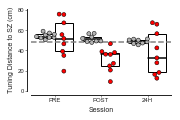

In [113]:
fig = plt.figure(figsize=(2.5, 1.5))
ax = fig.add_subplot(111)

sessions = ['PRE', 'POST', '24H']

grp_df = activity_centroid_df.groupby(['expt_id', 'session', 'stimmed'], as_index=False).mean()
sns.boxplot(x='session', y='abs_dist', hue='stimmed', data=grp_df,
              order=sessions, hue_order=['unstimmed', 'stimmed'], ax=ax,
              whis=False, showcaps=False, showfliers=False)
plt.setp(ax.artists, edgecolor='k', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='k')

sns.swarmplot(x='session', y='abs_dist', hue='stimmed', data=grp_df, palette=['0.7', 'r'],
              dodge=True, order=sessions, hue_order=['unstimmed', 'stimmed'], ax=ax, size=4,
              edgecolor='k', linewidth=0.5, alpha=1)

clean(ax, offset=4)
ax.set_ylabel('Tuning Distance to SZ (cm)')
ax.set_xlabel('Session')
ax.get_legend().remove()
ax.set_ylim([0, ax.get_ylim()[-1]])
# ax.set_yticks(range(0, 120, 20))
# ax.get_legend().remove()

ax.axhline(194./4, color='0.5', ls='--')

# fig.savefig(save_dir + 'activity_centroid_plot.svg', bbox_inches='tight')

# Stats
for session in ['POST', '24H']:
    
    pval = ttest_rel(stim_df['abs_dist'], nostim_df['abs_dist'])[1]

    print 'Activity Centroid Dist ({}): Stim={} {}, No Stim={} {}, p={}, {}'.format(
        session, stim_df.mean()['abs_dist'], stim_df['abs_dist'].sem(), nostim_df.mean()['abs_dist'], nostim_df['abs_dist'].sem(), pval, ttest_1samp(stim_df['abs_dist'], 194/4.)[1])

In [ ]:
### Shift

20.371071933 7.19835845866503
2.81677228411 1.778050466462279
Ttest_relResult(statistic=2.3361775226879327, pvalue=0.047699470493473346)
Ttest_1sampResult(statistic=2.829960754243158, pvalue=0.02215154906242607)
Ttest_1sampResult(statistic=1.584191414832286, pvalue=0.15180929746707045)


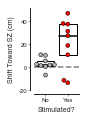

In [44]:
shift_df = activity_centroid_df.loc[(activity_centroid_df['session'] == 'POST')].merge(
    activity_centroid_df.loc[(activity_centroid_df['session'] == 'PRE')],
    on=['roi', 'mouse_name', 'stimmed'],
    suffixes=['_ind', '_base'])

shift_df['shift'] = shift_df.apply(lambda x: x['abs_dist_base'] - x['abs_dist_ind'], axis=1)

grp_df = shift_df.groupby(['mouse_name', 'stimmed', 'expt_id_ind'], as_index=False).mean()

fig = plt.figure(figsize=(0.8, 1.5))
ax = fig.add_subplot(111)

ax.axhline(0, color='0.7', alpha=0.5, ls='--')

sns.boxplot(x='stimmed', y='shift', data=grp_df, color='k',
            order=['unstimmed', 'stimmed'], ax=ax,
            whis=False, showcaps=False, showfliers=False)
plt.setp(ax.artists, edgecolor='k', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='k')

sns.swarmplot(x='stimmed', y='shift', hue='stimmed', data=grp_df, palette=['0.7', 'r'],
              order=['unstimmed', 'stimmed'], hue_order=['unstimmed', 'stimmed'], ax=ax, size=4,
              edgecolor='k', linewidth=0.5, alpha=1)

ax.get_legend().remove()

clean(ax, offset=4)
ax.set_ylabel('Shift Toward SZ (cm)')
ax.set_xlabel('Stimulated?')
ax.set_xticklabels(['No', 'Yes'])
ax.set_yticks([-20, 0, 20, 40])
ax.set_yticklabels(["-20", "0", "20", "40"])

fig.savefig(save_dir + 'shifts.svg')

stim_df = grp_df.loc[(grp_df['stimmed'] == 'stimmed')]
nostim_df = grp_df.loc[(grp_df['stimmed'] == 'unstimmed')]

print stim_df['shift'].mean(), stim_df['shift'].sem()
print nostim_df['shift'].mean(), nostim_df['shift'].sem()
print ttest_rel(stim_df['shift'], nostim_df['shift'])
print ttest_1samp(stim_df['shift'], 0)
print ttest_1samp(nostim_df['shift'], 0)

### Stim Response vs Distance

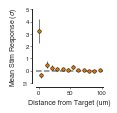

In [9]:
# Max across all single cell stim experiments 
max_dist = 168.5935987978145

amps = pd.read_pickle(data_dir + 'amps.pkl')
dists = pd.read_pickle(data_dir + 'dists.pkl')

full_df = dists.merge(amps, on=['mouse_name', 'expt_id', 'roi'])
df = full_df.loc[full_df['dist'] <= max_dist]

zeros = df.loc[df['dist'] == 0]['zdiff']
rest = df.loc[df['dist'] > 0]
means, bins, _ = binned_statistic(rest['dist'], rest['zdiff'],
                                      statistic=np.mean,
                                      bins=np.linspace(0, max_dist, 21))

stds, bins, _ = binned_statistic(rest['dist'], rest['zdiff'],
                                      statistic=sem,
                                      bins=np.linspace(0, max_dist, 21))

bin_size = bins[1] - bins[0]
zero_mean = np.nanmean(zeros)
zero_std = sem(zeros)

means = np.concatenate([[zero_mean], means])[:-8]
stds = np.concatenate([[zero_std], stds])[:-8]
plot_bins = np.concatenate([[0], bins + (bins[1] - bins[0]) / 2.])[:-8]

fig = plt.figure(figsize=(1.2, 1.35))
ax = fig.add_subplot(111)

color = sns.xkcd_palette(['pumpkin'])[0]
ax.errorbar(plot_bins[:-1], means, yerr=stds, fmt='o', mfc=color, mec='k', ecolor='k', ms=3.5, elinewidth=0.5, mew=0.5)
clean(ax, offset=4)
ax.set_xlabel('Distance from Target (um)')
ax.set_ylabel('Mean Stim Response ($\sigma$)')

ax.axhline(0, color='0.5', ls='--')

# ax.set_yticks(range(-1, 6, 2))
ax.set_ylim([-1, 5])

fig.savefig(save_dir + 'stim_response_vs_dist_clipped.svg')

### Tuning Change

In [45]:
def tuning_difference(grp, bgrp, roi_filter=None, by_mouse=False,
                       normalize=False):

    """Return mean difference of tuning curves.
    """

    all_diffs = []
    mean_diffs = []
    
    fulldata = grp.data(roi_filter=None)
    data = grp.data(roi_filter=roi_filter)
    
    bfulldata = bgrp.data(roi_filter=None)
    bdata = bgrp.data(roi_filter=roi_filter)

    for expt, bexpt in zip(grp, bgrp):

        stim_loc = expt._get_stim_positions(units='normalized')[0]
        shift = 50 - int(stim_loc)

        if normalize:

            mean2 = np.nanmean(fulldata[expt], axis=0, keepdims=True)
            mean1 = np.nanmean(bfulldata[bexpt], axis=0, keepdims=True)

            mean_diff = mean2 - mean1
            diffs = data[expt] - bdata[bexpt] - mean_diff

        else:
            diffs = data[expt] - bdata[bexpt]

        diffs = np.roll(diffs, shift, axis=1)

        # Convert from frames to seconds
        diffs = diffs / expt.frame_period()

        if by_mouse:
            all_diffs.append(np.nanmean(diffs, axis=0))
        else:
            all_diffs.extend(diffs)
        
        if normalize:
            mean_diffs.extend(np.roll(mean_diff, shift, axis=1) / expt.frame_period())
            
    if normalize:
        return all_diffs, mean_diffs
    else:
        return all_diffs, None

In [46]:
bgrp = pcExperimentGroup([x._get_session('control_baseline') for x in grp], **grp.args)

In [47]:
stim_diff, _ = tuning_difference(grp, bgrp, normalize=True, roi_filter=stim_filter, by_mouse=False)
nostim_diff, _ = tuning_difference(grp, bgrp, normalize=True, roi_filter=nostim_filter, by_mouse=False)

In [50]:
save_dir

'/home/sebi/plots/ind/fig3/'

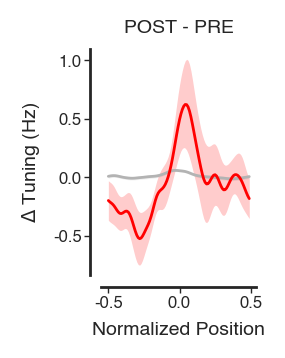

In [51]:
fig = plt.figure(figsize=(1, 1.5), dpi=200)
ax = fig.add_subplot(111)

bin_to_cm = grp[0].track_length / 1000.

stim_mean = np.nanmean(stim_diff, axis=0)
stim_sem = sem(stim_diff, axis=0)

nostim_mean = np.nanmean(nostim_diff, axis=0)
nostim_sem = sem(nostim_diff, axis=0)

x = np.arange(-50, 50) / 100.

# ax.axvline(0, color='k', ls='--')

ax.plot(x, nostim_mean, color='0.7', lw=1)
ax.fill_between(x, nostim_mean-nostim_sem, nostim_mean+nostim_sem, color='0.7', alpha=0.2, lw=0)
ax.plot(x, stim_mean, color='r', lw=1)
ax.fill_between(x, stim_mean-stim_sem, stim_mean+stim_sem, color='r', alpha=0.2, lw=0)

clean(ax, offset=4)
ax.set_xlabel('Normalized Position')
ax.set_ylabel('$\Delta$ Tuning (Hz)')
ax.set_title('POST - PRE')

fig.savefig(save_dir + 'tuning_difference.svg', bbox_inches='tight')

### Example Raster

1


(-21, 0)

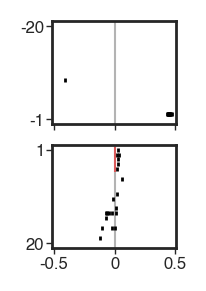

In [12]:
fig = plt.figure(figsize=(0.8, 1.5), dpi=200)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


roi_label='0000-0172-0392-6031974970479320307'
roi_filter = lambda x: x.label == roi_label

cell_idx = 0

expt = grp[4]
print len(expt.rois(roi_filter=roi_filter))
spikes = expt.spikes(binary=True, roi_filter=roi_filter)[cell_idx, ...]

abspos = ba.absolutePosition(expt.find('trial'))
pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
laps = abspos.astype(int)
running = expt.velocity()[0] > 1

# Baseline Info
bexpt = expt._get_session('control_baseline')
bspikes = bexpt.spikes(binary=True, roi_filter=roi_filter)[cell_idx, ...]
babspos = ba.absolutePosition(bexpt.find('trial'))
bpos = ((babspos * 100).astype(int) / 100.) % 1
blaps = babspos.astype(int)
brunning = bexpt.velocity()[0] > 1

shift = (50-int(expt._get_stim_positions(units='normalized')[0]))/100.

# Plot last 20 laps of baseline session
ax1.axvline(.5, color='0.7', lw=0.75)
spike_idx = np.where(bspikes)[0]
n_laps = blaps[-1]
start_lap = n_laps - n_lap_display - 1

for spike_i in spike_idx:
    if not brunning[spike_i]:
        continue
    lap = int(babspos[spike_i])
    if lap <= start_lap:
        continue
    elif lap == n_laps:
        break
    pos = (babspos[spike_i] + shift) % 1
    ax1.plot(pos, start_lap-lap, marker='|', color='k', ms=1.5)

ax1.set_xlim([-0.01, 1])
ax1.set_xticks([0, .50, .99])
ax1.set_xticklabels([])
ax1.set_yticks([-1, -n_lap_display])
ax1.set_yticklabels([-n_lap_display, -1])
ax1.set_ylim([-n_lap_display - 1, 0])


# Plot first 20 laps of induction session
ax2.axvline(.5, color='0.7', lw=0.75)
ax2.vlines(x=0.5, ymin=-5.5, ymax=-0.5, color='r', alpha=0.5, zorder=100, lw=0.75)

spike_idx = np.where(spikes)[0]
for spike_i in spike_idx:
    if not running[spike_i]:
        continue
    lap = int(abspos[spike_i])
    # Lap 0 is not complete so skip
    if lap == 0:
        continue
    if lap > 20:
        break
    pos = (abspos[spike_i] + shift) % 1
    
    ax2.plot(pos, -lap, marker='|', color='k', ms=1.5)
    
ax2.set_xlim([-0.01, 1])
ax2.set_xticks([0, .50, .99])
ax2.set_xticklabels([-0.5, 0, 0.5], rotation=0)
ax2.set_yticks([-1, -n_lap_display])
ax2.set_yticklabels([1, n_lap_display])
ax2.set_ylim([-n_lap_display - 1, 0])   

# ax.set_ylabel('Lap')
# ax.set_xlabel('Normalized Position')
# ax.set_title('Example Cell')
# fig.savefig('/home/sebi/plots/ind/figs_led_example/svr180_c1_example_raster.svg')

1


(-21, 0)

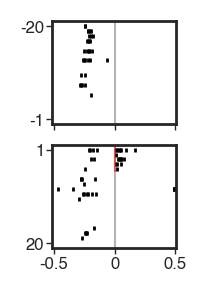

In [38]:
fig = plt.figure(figsize=(0.8, 1.5), dpi=200)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


# roi_label='0000-0172-0392-6031974970479320307'
# roi_filter = lambda x: x.label == roi_label

# roi_filter = ind_filter #e8c0
roi_filter = lambda x: stim_filter(x) and not ind_filter(x) #e5c0

cell_idx = 0

expt = grp[5]
print len(expt.rois(roi_filter=roi_filter))
spikes = expt.spikes(binary=True, roi_filter=roi_filter)[cell_idx, ...]

abspos = ba.absolutePosition(expt.find('trial'))
pos = ((abspos * 100).astype(int) / 100.) % 1 # relative position rounded to two decimals
laps = abspos.astype(int)
running = expt.velocity()[0] > 1

# Baseline Info
bexpt = expt._get_session('control_baseline')
bspikes = bexpt.spikes(binary=True, roi_filter=roi_filter)[cell_idx, ...]
babspos = ba.absolutePosition(bexpt.find('trial'))
bpos = ((babspos * 100).astype(int) / 100.) % 1
blaps = babspos.astype(int)
brunning = bexpt.velocity()[0] > 1

shift = (50-int(expt._get_stim_positions(units='normalized')[0]))/100.

# Plot last 20 laps of baseline session
ax1.axvline(.5, color='0.7', lw=0.75)
spike_idx = np.where(bspikes)[0]
n_laps = blaps[-1]
start_lap = n_laps - n_lap_display - 1

for spike_i in spike_idx:
    if not brunning[spike_i]:
        continue
    lap = int(babspos[spike_i])
    if lap <= start_lap:
        continue
    elif lap == n_laps:
        break
    pos = (babspos[spike_i] + shift) % 1
    ax1.plot(pos, start_lap-lap, marker='|', color='k', ms=1.5)

ax1.set_xlim([-0.01, 1])
ax1.set_xticks([0, .50, .99])
ax1.set_xticklabels([])
ax1.set_yticks([-1, -n_lap_display])
ax1.set_yticklabels([-n_lap_display, -1])
ax1.set_ylim([-n_lap_display - 1, 0])


# Plot first 20 laps of induction session
ax2.axvline(.5, color='0.7', lw=0.75)
ax2.vlines(x=0.5, ymin=-5.5, ymax=-0.5, color='r', alpha=0.5, zorder=100, lw=0.75)

spike_idx = np.where(spikes)[0]
for spike_i in spike_idx:
    if not running[spike_i]:
        continue
    lap = int(abspos[spike_i])
    # Lap 0 is not complete so skip
    if lap == 0:
        continue
    if lap > 20:
        break
    pos = (abspos[spike_i] + shift) % 1
    
    ax2.plot(pos, -lap, marker='|', color='k', ms=1.5)
    
ax2.set_xlim([-0.01, 1])
ax2.set_xticks([0, .50, .99])
ax2.set_xticklabels([-0.5, 0, 0.5], rotation=0)
ax2.set_yticks([-1, -n_lap_display])
ax2.set_yticklabels([1, n_lap_display])
ax2.set_ylim([-n_lap_display - 1, 0])   

# ax.set_ylabel('Lap')
# ax.set_xlabel('Normalized Position')
# ax.set_title('Example Cell')
# fig.savefig(save_dir + 'example_failure_cell_raster.svg')

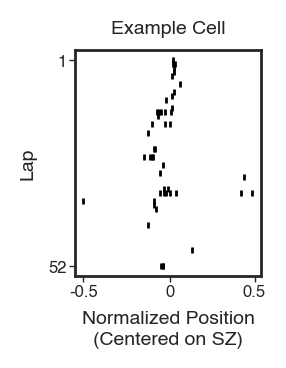

In [10]:
expt = grp[4]
roi_label='0000-0172-0392-6031974970479320307'
roi_filter = lambda x: x.label == roi_label

spikes = expt.spikes(roi_filter=roi_filter, binary=True)[0, ...]
abs_pos = ba.absolutePosition(expt.find('trial'), imageSync=True)

shift = (50 - int(expt._get_stim_positions(units='normalized')[0]))/100.

fig = plt.figure(figsize=(1.2, 1.5), dpi=200)
ax = fig.add_subplot(111)

spike_idx = np.where(spikes)[0]
for spike_i in spike_idx:
    lap = int(abs_pos[spike_i])
    pos = (abs_pos[spike_i] + shift) % 1
    
    ax.plot(pos, -lap, marker='|', color='k')

ax.set_xticks([0, .50, .99])
ax.set_xticklabels([-0.5, 0, 0.5], rotation=0)
ax.set_yticks([-1, -lap])
ax.set_yticklabels([1, lap])
ax.set_ylabel('Lap')
ax.set_xlabel('Normalized Position\n(Centered on SZ)')
ax.set_title('Example Cell')

fig.savefig(save_dir + 'example_cell_raster.svg')

## Data Functions

In [3]:
save_dir = '/home/sebi/plots/ind/fig3/'
data_dir = '/home/sebi/data/induction/fig3/'

In [3]:
def activity_centroids(grp, stim_filter, 
                            nostim_filter=None):
    
    full_sessions = ['control_baseline', 'control_induction', 'control_24h']

    session_name_dict = {'induction': 'POST',
                         'baseline': 'PRE',
                         '24h': '24H'}

    if not nostim_filter:
        nostim_filter = lambda x: not stim_filter(x)

    df = pd.DataFrame([])

    for session in full_sessions:

        sess_grp = [x._get_session(session) for x in grp]
        sess_grp = pcExperimentGroup(sess_grp, **grp.args)

        stim_session = session.split('_')[0] + '_induction'

        for stimmed, sfilter in zip(['stimmed', 'unstimmed'], [stim_filter, nostim_filter]):

            sess_df = ia.activity_centroid_distance(sess_grp, roi_filter=sfilter, stim_session=stim_session)
            sess_df['stimmed'] = stimmed
            sess_df['session'] = session_name_dict[session.split('_')[-1]]

            df = pd.concat([df, sess_df])

    return df

In [6]:
activity_centroid_df = activity_centroids(grp, stim_filter, nostim_filter)
activity_centroid_df.to_pickle(data_dir + 'activity_centroid_df.pkl')

In [40]:
activity_centroid_df = pd.read_pickle(data_dir + 'activity_centroid_df.pkl')

In [7]:
ind_rate = ia.induction_rate(grp, stim_filter, ind_filter, nostim_filter, nostim_ind_filter)
ind_rate.to_pickle(data_dir + 'ind_rate.pkl')

In [4]:
ind_rate = pd.read_pickle(data_dir + 'ind_rate.pkl')

In [8]:
amps = ia.burst_size(grp, roi_filter=None, win=(1, 0.5), exclude_stim=True)
dists = ia.dist_to_target(grp, stim_filter=None)

amps.to_pickle(data_dir + 'amps.pkl')
dists.to_pickle(data_dir + 'dists.pkl')

In [12]:
stim_td = ia.tuning_difference(grp, roi_filter=stim_filter, by_mouse=False)
nostim_td = ia.tuning_difference(grp, roi_filter=nostim_filter, by_mouse=False)
with open(data_dir + 'tuning_differences.pkl', 'wb') as fw:
    pkl.dump([stim_td, nostim_td], fw)